# SQUANCH Test

Small test of the SQUANCH (https://github.com/att-innovate/squanch) framework for simulation of quantum channels.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from squanch import *

Quantum teleportation example, from the paper [Bartlett 2018].

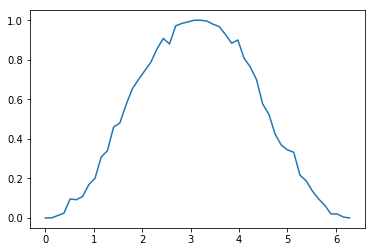

In [2]:
class Alice(Agent):
    
    def distribute_bell_pair(self, a, b):
        H(a)
        CNOT(a, b)
        self.qsend(bob, b)
    
    def teleport(self, q, a):
        CNOT(q, a)
        H(q)
        
        apply_x = a.measure()
        apply_z = q.measure()
        self.csend(bob, [apply_x, apply_z])
    
    def run(self):
        for qsystem in self.qstream:
            q, a, b = qsystem.qubits
            self.distribute_bell_pair(a, b)
            self.teleport(q, a)

class Bob(Agent):
    
    def run(self):
        measurement_results = []
        for _ in self.qstream:
            b = self.qrecv(alice)
            # get corrections necessary for correction on the qubit
            apply_x, apply_z = self.crecv(alice)
            if apply_x:
                X(b)
            if apply_z:
                Z(b)
            
            measurement_results.append(b.measure())
        self.output(measurement_results)

angles = np.linspace(0, 2 * np.pi)
num_trials = 250

stream = QStream(3, len(angles) * num_trials)
for angle in angles:
    for _ in range(num_trials):
        q, _, _ = stream.next().qubits
        RX(q, angle)

out = Agent.shared_output()
alice = Alice(stream, out=out)
bob = Bob(stream, out=out)
alice.qconnect(bob)
alice.cconnect(bob)

Simulation(alice, bob).run()

bob_out = out["Bob"]

count = 0
probabilities = []
for angle in angles:
    prob = 0
    for _ in range(num_trials):
        prob += bob_out[count] * 1/num_trials
        count +=1
    probabilities.append(prob)

plt.plot(angles, probabilities)
plt.show()

## References

[Bartlett 2018] B. Bartlett, "A distributed simulation framework for quantum networks and channels", arXiv 1808.07047, 2018